<a href="https://colab.research.google.com/github/haneulllll/DataStudy/blob/main/%EB%B3%B5%EC%8A%B5_%EC%9D%B4%ED%95%9C%EC%9D%8486_0505.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이상치 탐지

**라이브러리 불러오기**

1. Numpy(np) : 계산을 위한 패키지

2. Pandas(pd) : 데이터분석을 위한 패키지 (DataFrame, Series 같은 데이터 구조를 제공)

3. Seaborn(sns) : 통계데이터 시각화 라이브러리

**IsolationForest**

: 이상치 탐색 알고리즘

how ? 특정 feature을 무작위로 선택 후 feature의 최대값과 최소값 사이에서 무작위로 분할 값을 선택하여 관측치를 격리

**make_blobs**
: 클러스터링(그룹화) 및 분류작업을 위한 함수

**Seasonal Decompose**

: 시계열 데이터를 추세/계절 등으로 분해하는 알고리즘

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

#이상치 탐지 방법
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs

#이상치 탐지 방법(시계열 데이터)
from statsmodels.tsa.seasonal import seasonal_decompose


**이상치가 존재하는 데이터 생성하기**

In [ ]:
# 평균이 50이고 표준편차가 20인 정규분포를 따르는 100개의 데이터를 생성
data = np.random.randn(100) * 20 + 50
# 데이터에 이상치를 추가
data = np.append(data, [200, -100, 150])

# 데이터 -> DataFrame 으로 변환
df = pd.DataFrame(data, columns=['Data'])

df # 100,101,102번째 값이 이상치임을 확인할 수 있음

,Data
0,53.985788
1,49.635487
2,76.560396
3,45.620248
4,73.337654
...,...
98,58.629136
99,38.589784
100,200.000000
101,-100.000000


# 1. IQR을 이용하여 이상치 탐지하기

IQR(사분범위) : 데이터의 중간 50%를 나타내는 측정 지표

how ? 주로 이상치는  Q1 - 1.5 X IQR 보다 작은값이나 Q3 + 1.5 X IQR 보다 큰 값으로 정의

In [ ]:
# df의 'Data'열에서 25번째 백분위수(Q1)와 75번째 백분위수(Q3)를 계산하기
# => 데이터의 아래쪽 25%와 위쪽 25%의 경계를 찾는다.
Q1 = df['Data'].quantile(0.25)
Q3 = df['Data'].quantile(0.75)

# IQR 계산
IQR = Q3 - Q1

# 이상치 식별을 위한 경계를 정의
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# df에서 이상치를 식별
outliers = df[(df['Data'] < lower_bound) | (df['Data'] > upper_bound)]

outliers

,Data
23,107.933932
34,-8.055101
53,-4.798256
94,-5.849855
100,200.000000
101,-100.000000
102,150.000000


In [ ]:
print("Q1 :" , Q1)
print("Q3 :", Q3)
print("IQR :", IQR)
print("이상치 식별 경계 :",lower_bound ,",", upper_bound)
print("이상치 : ")
print(outliers)

Q1 : 37.2688968045247
Q3 : 64.0461675020531
IQR : 26.777270697528394
이상치 식별 경계 : -2.89700924176789 , 104.21207354834569
이상치 : 
           Data
23   107.933932
34    -8.055101
53    -4.798256
94    -5.849855
100  200.000000
101 -100.000000
102  150.000000


# 2. IsolationForest을 이용하여 이상치 탐지하기

make_blobs(n_samples, centers, random_state)
- n_samples : 생성할 데이터의 총 개수
- centers : 생성할 클러스터의 개수
- random_state : 난수 생성시드를 설정( 동일한 시드를 사용하여 시작하도록 강제 -> 결과의 재현을 보장)

**이상치를 담은 데이터 생성**

In [ ]:
# 중심점 3개인 데이터 생성
data, _ = make_blobs(n_samples = 300, centers=3, random_state=111)

# 이상치를 생성 ( 2차원공간에서 -10~10 범위의 20개의 난수(점) 생성 )

outliers = np.random.uniform(low=-10, high=10, size=(20,2))

# 기존 data에 이상치를 추가(수직으로 합친다)

data =np.vstack([data, outliers])

**모델 생성 및 학습(이상치 탐지)**

contamination
: 이상치가 차지하는 비율 ( 0~1 사이의 실수로 표현)

- 기본은 'auto' => 데이터셋에따라 자동으로 이상치를 탐지

- 1에 가까운 경우 => 더 많은 데이터셋이 이상치로 탐지됨.(False Positive 증가하는 경우)

- 0에 가까운 경우 => 이상치로 판단되는 데이터셋 수가 줄어듬.(False Negative 증가하는 경우)

In [ ]:
# Isolation Forest 모델 생성
model = IsolationForest(n_estimators = 100,contamination=0.3, random_state=111)

# 모델을 이용하여 학습 -> 데이터의 이상치를 예측
predictions = model.fit_predict(data)

**모델의 예측결과를 시각화**

plt.scatter(x축,y축, c, cmap, marker, s, edgecolor)

- x축 : data[:,0] -> 'data'의 모든 행의 첫번째 열을 선택

- y축 : data[:,1] -> 'data'의 모든 행의 두번째 열을 선택

- c : predictions -> 각 데이터포인트에 대한 색상을 지정

- cmap : Paird -> 색상 맵을 설정 (각 레이블에 대해 서로다른 색상을 지정)

- marker : 'o' -> 데이터포인트의 모양을 설정

- s : 30 -> 데이터포인트의 크기 설정

- edgecolor : 'k' -> 데이터포인트의 테두리 색상을 설정
ex) k(검정색) / b(파란색) / y(노란색) / r(빨간색)

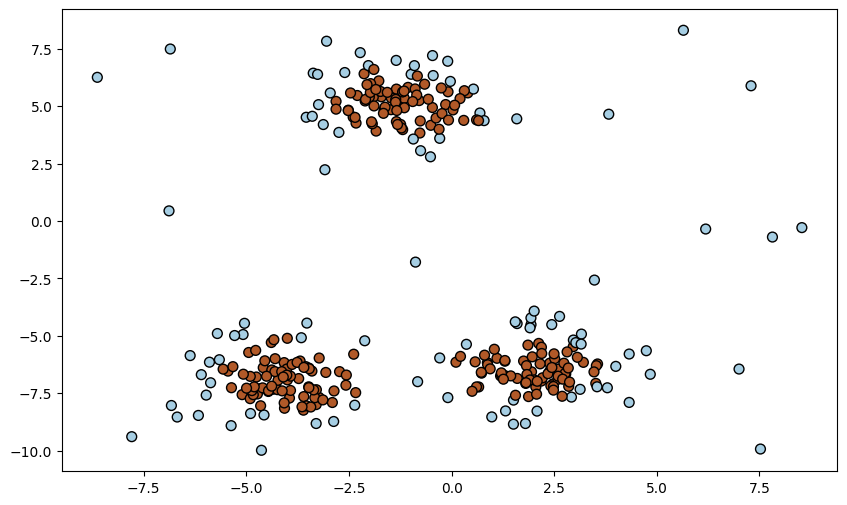

In [ ]:
# 새로운 Figure 객체를 생성(가로 길이 10인치, 세로 길이 6인치)
plt.figure(figsize=(10,6))
plt.scatter(data[:,0], data[:,1], c =predictions, cmap='Paired', marker='o', s=50, edgecolor='k')

In [ ]:
print(predictions) # 이상치는 -1 / 정상데이터는 1

[ 1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1 -1 -1  1  1
  1  1  1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1 -1  1  1  1  1
  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1 -1  1  1 -1
 -1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1
  1 -1  1 -1 -1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1
 -1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1
 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1 -1 -1  1 -1  1  1  1  1  1  1 -1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1 -1  1  1 -1
  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1
  1 -1 -1 -1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1
  1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
model

IsolationForest(contamination=0.3, random_state=111)

# 3. 시계열 데이터를 이용하여 이상치 탐지하기

**이상치를 담은 시계열데이터 생성**

cumsum() : 누적합을 계산하여 데이터 생성 => 시간에 따라 변하는 시계열데이터와 유사

In [ ]:
# 시계열데이터 생성
np.random.seed(111)
data= np.random.randn(100).cumsum() + 100

# 데이터에 이상치 추가
data[15] +=50
data[50] -=20
data[75] +=30

**이상치 탐지**

rolling() : 이동평균과 이동표준편차를 계산하는 함수

how ?
주로 이상치는  평균 - 1.5 X 표준편차 보다 작은값이나 평균 + 1.5 X 표준편차 보다 큰 값으로 정의

In [ ]:
# 이동평균과 이동표준편차 계산

window_size = 5
moving_average = pd.Series(data).rolling(window = window_size).mean()
moving_std = pd.Series(data).rolling(window = window_size).std()

# 이상치 탐지 기준 설정

upper_bound = moving_average + 1.5 * moving_std
lower_bound = moving_average - 1.5 * moving_std

# 데이터프레임 생성하여 데이터의 변화/이상치를 시각적으로 확인
df = pd.DataFrame({'Data':data, 'Moving Average':moving_average, 'upper_bound':upper_bound,'lower_bound':lower_bound})

# 이상치 탐지
outliers =df[(df['Data'] > df['upper_bound'])| (df['Data'] < df['lower_bound'])]

outliers

,Data,Moving Average,upper_bound,lower_bound
8,97.995815,98.912292,99.810825,98.013760
9,96.811875,98.353844,99.817615,96.890072
12,95.020263,96.667914,98.291842,95.043986
15,144.675013,105.343218,138.339091,72.347346
22,95.762267,96.665012,97.469861,95.860164
33,96.355747,98.185490,100.012112,96.358867
38,95.320520,96.548054,97.631589,95.464518
45,94.386008,93.204384,94.333209,92.075560
50,77.584493,92.863052,105.795264,79.930839
61,97.289380,99.601719,101.677807,97.525631


**데이터 시각화**

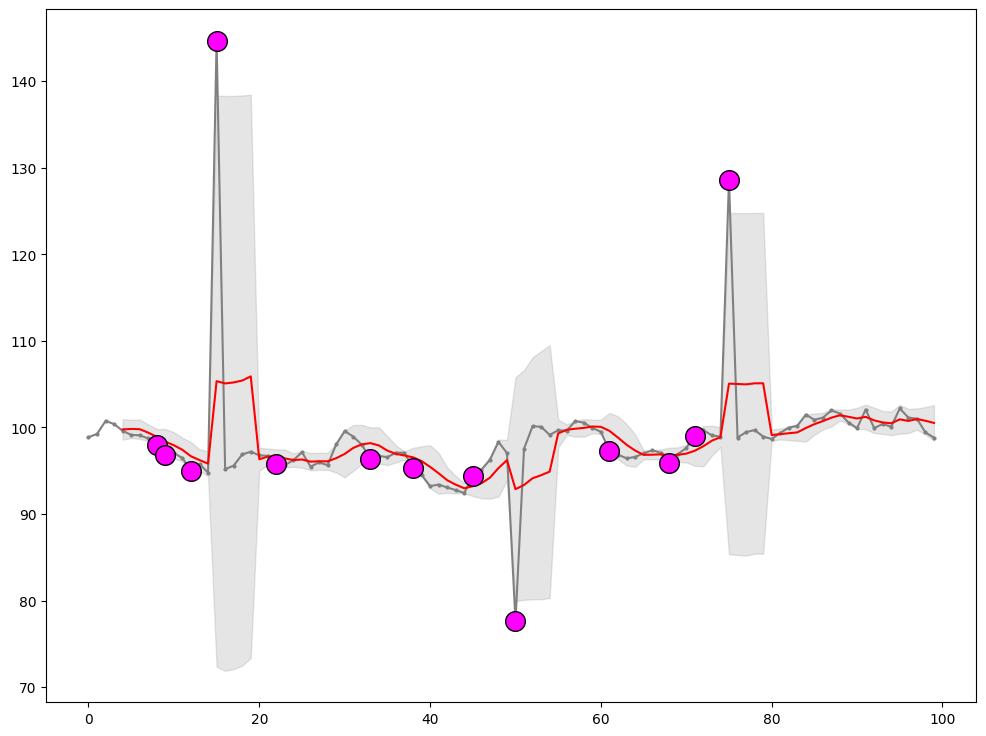

In [ ]:
# 시각화로 확인해 보기
plt.figure(figsize=(12,9))
plt.plot(df['Data'], label='Data', color='gray', marker='o', markersize=2, linestyle='-')
plt.plot(df['Moving Average'], color='red',label='Moving average')
plt.fill_between(df.index, df['upper_bound'], df['lower_bound'], color='gray', alpha=0.2, label='Confidence Interval')
plt.scatter(outliers.index, outliers['Data'], color='magenta', label='Outliers', s=200, edgecolor='black',zorder=5)


In [ ]:
print("data : ", data)
print("이동평균 : ")
print(moving_average)
print("이동표준편차 : ")
print(moving_std)

data :  [ 98.86616167  99.25048086 100.74703464 100.39165234  99.6041188
  99.14467989  99.08551112  98.73133762  97.99581456  96.81187468
  97.05076881  96.46084855  95.02026343  95.79396654  94.76599921
 144.67501296  95.16701596  95.59168816  96.87473698  97.19072343
  96.78264123  96.71469364  95.76226698  95.65158958  96.22218387
  97.13760404  95.46826353  95.95097718  95.64050451  98.03519424
  99.58612516  98.93965998  98.01072274  96.3557466   96.7059391
  96.56418259  97.08526437  97.06436351  95.32051956  94.52136068
  93.21779025  93.39589526  93.06149289  92.75546576  92.42306019
  94.38600753  95.10525002  96.24813653  98.3310135   97.04636575
  77.58449336  97.53995395 100.13711832 100.07885204  99.13356504
  99.67473743  99.61972855 100.73974935 100.5481064   99.93796798
  99.49338913  97.28937983  96.85870935  96.43361589  96.58090788
  97.00583216  97.3530899   97.07685435  95.87455873  96.90558203
  97.62890099  99.06167971  99.67118658  99.08703103  98.92915606
 128

# Decompose 패키지 이용

seasonal_decompose() : 시계열데이터를 계절성, 추세, 잔차로 분해

how ? 분해된 시계열 데이터에서 잔차를 추출한 후 잔차의 절대값이 잔차의 표준편차의 2배보다 큰 값을 이상치로 판별

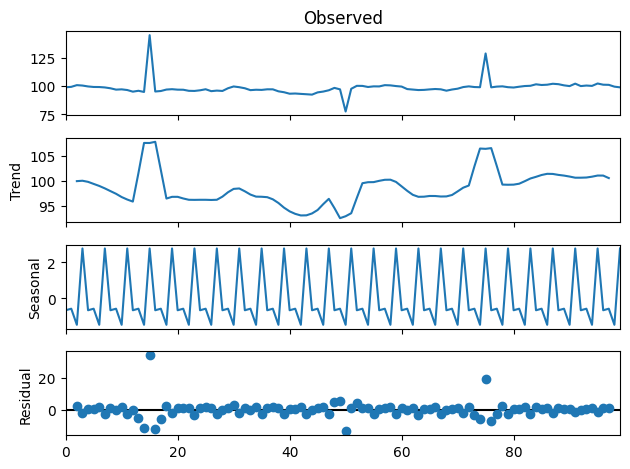

In [ ]:
# 시계열 분해 후 결과를 시각화
result = seasonal_decompose(data, model ='additive',period=4)
result.plot()

# 잔차를 통한 이상치 탐지
residuals = result.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()]